In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from neuralprophet import NeuralProphet, uncertainty_evaluate, set_log_level, set_random_seed, df_utils
import logging
import warnings
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
# Disable logging messages unless there is an error
set_log_level("ERROR")

d:\conda_envs\prophet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


(948, 3) (105, 3) (116, 3) (292, 3)


,ds,y,temperature,summer,winter,spring,fall
0,2015-01-01,64.92,3.85,0,1,0,0
1,2015-01-02,58.46,4.80,0,1,0,0
2,2015-01-03,63.35,5.68,0,1,0,0
3,2015-01-04,50.54,6.49,0,1,0,0
4,2015-01-05,64.89,5.90,0,1,0,0


,ds,y,temperature,summer,winter,spring,fall
1456,2018-12-27,70.82,7.52,0,1,0,0
1457,2018-12-28,68.61,8.00,0,1,0,0
1458,2018-12-29,60.22,7.96,0,1,0,0
1459,2018-12-30,57.69,6.99,0,1,0,0
1460,2018-12-31,60.32,7.41,0,1,0,0


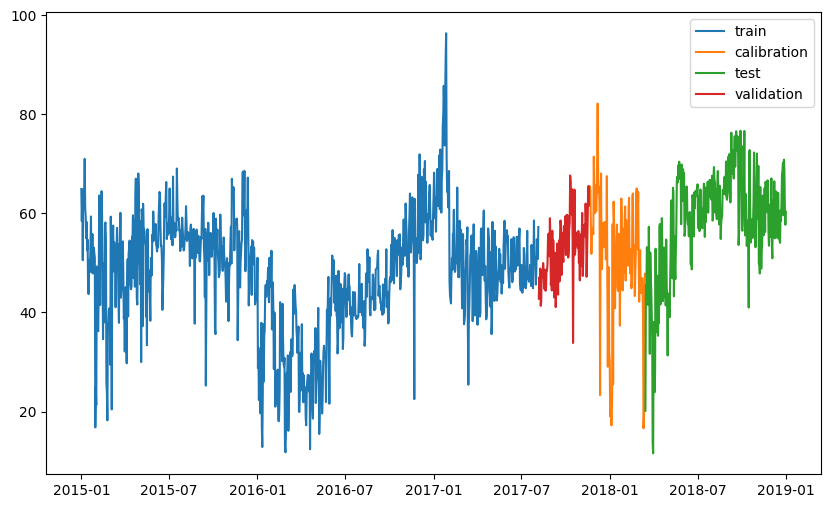

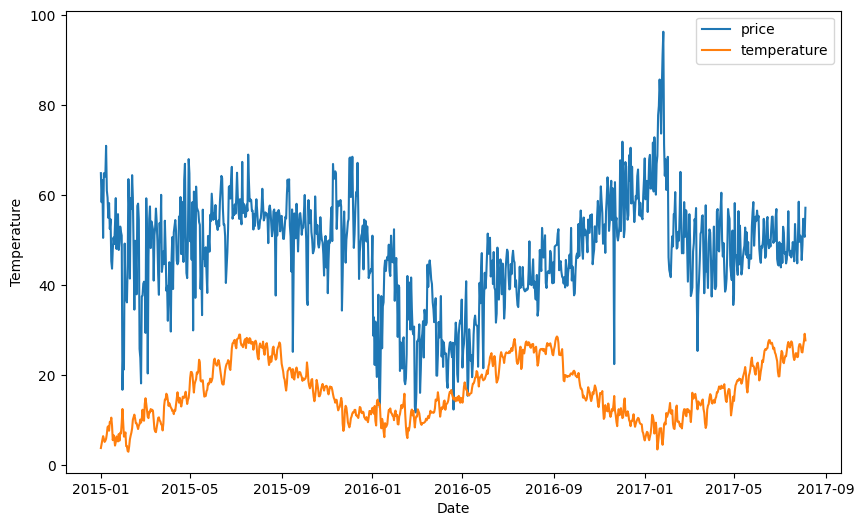

In [2]:
# data preparation
df = pd.read_csv('dataset/energy_load_with_temp.csv')

# convert temperature to celsius from kelvin
df['temperature'] = df['temperature'] - 273.15


m = NeuralProphet() # create an instance of NeuralProphet
df['ds'] = pd.to_datetime(df['ds']) # convert the 'ds' column to datetime
df_train, df_test = m.split_df(df, freq="D", valid_p=0.2) # split the data into training and testing sets with a validation set of 1/16
df_train, df_cal = m.split_df(df_train, freq="D", valid_p=0.1) # split the training set into training and calibration sets with a validation set of 1/11
df_train, df_val = m.split_df(df_train, freq="D", valid_p=0.1) # split the training set into training and validation sets with a validation set of 1/6
print(df_train.shape, df_val.shape, df_cal.shape, df_test.shape)

# add seasonality
df = df_utils.add_quarter_condition(df) # add four seasons

display(df.head())
display(df.tail())

# plot the data split
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(df_train.ds, df_train.y, label="train")
ax.plot(df_cal.ds, df_cal.y, label="calibration")
ax.plot(df_test.ds, df_test.y, label="test")
ax.plot(df_val.ds, df_val.y, label="validation")
ax.legend()
plt.show()

# plot the data as multiple time series
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(df_train.ds, df_train.y, label="price")
ax.plot(df_train.ds, df_train['temperature'], label="temperature")
ax.set_ylabel("Price")
ax.set_ylabel("Temperature")
ax.set_xlabel("Date")
ax.legend()

Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 90.56it/s, loss=0.0292, v_num=119, MAE_val=4.650, RMSE_val=6.040, Loss_val=0.0352, RegLoss_val=0.000, MAE=5.070, RMSE=6.680, Loss=0.030, RegLoss=0.000]    
Loss        0.030049
Loss_val    0.035206
Name: 29, dtype: float64


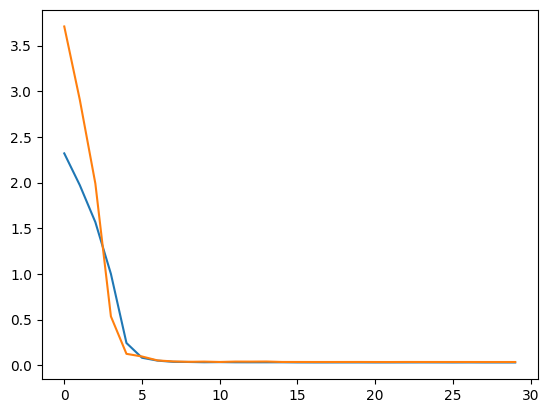

In [3]:
set_random_seed(0)
confidence_lv = 0.9
quantile_list = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)] # 0.05 and 0.95 quantiles
n_lags = 5

# autoregression model with multiple layers
cp_model2 = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_changepoints=10,
    n_lags=n_lags,
    ar_layers=[32,32,32,32],
    # lagged_reg_layers=[32,32,32,32],
    learning_rate=0.001,
    quantiles=quantile_list,
)
cp_model2.set_plotting_backend("plotly-static")

# lagged features
# cp_model2.add_lagged_regressor("temperature", n_lags=n_lags)
# future regressors
cp_model2.add_future_regressor("temperature")

# # add conditional seasonality
# quarters = ["summer", "fall", "winter", "spring"]
# for quarter in quarters:
#     cp_model2.add_seasonality(name=quarter, period=91.25, fourier_order=5, condition_name=quarter)

metrics2 = cp_model2.fit(df_train, validation_df=df_val, freq="D", progress="plot", epochs=30)
print(metrics2.iloc[-1][["Loss", "Loss_val"]]) # print the loss values

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.43it/s]


Autoregression Model            yhat1                 
  interval_width miscoverage_rate
0      54.932701         0.017483


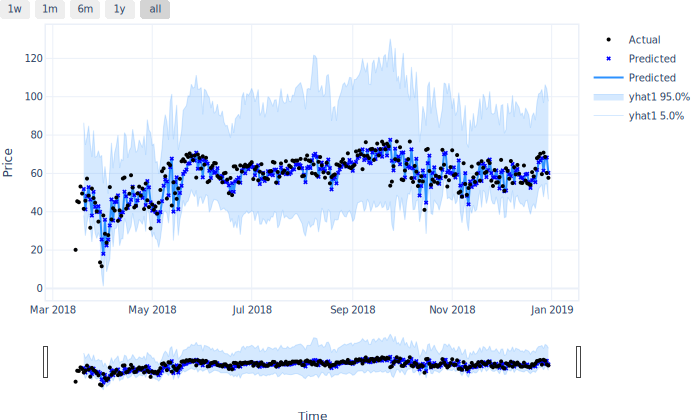

In [5]:
# evaluate the model

# Conformalized Quantile Regression (CQR) model
# parameters
method = "cqr" # conformalized quantile regression
alpha = 1 - confidence_lv # significance level

cqr_forecast2 = cp_model2.conformal_predict(df_test,calibration_df=df_cal, method=method, alpha=alpha, plotting_backend="plotly-static")
cqr_metrics2 = uncertainty_evaluate(cqr_forecast2) # evaluate the autoregression model
print("Autoregression Model", cqr_metrics2)

# Plot the forecast with the confidence interval
# cutoff = 60 # 7 days
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[:], plotting_backend="plotly-static", figsize=(10, 6), xlabel="Time", ylabel="Price"
)
